In [209]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [210]:
df = pd.read_csv('df_scaled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 41 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   povertyPercentage                 197914 non-null  float64
 1   males_percentage_per_city         197914 non-null  float64
 2   females_percentage_per_city       197914 non-null  float64
 3   killed_percentage_per_district    197914 non-null  float64
 4   injured_percentage_per_district   197914 non-null  float64
 5   arrested_percentage_per_district  197914 non-null  float64
 6   unharmed_percentage_per_district  197914 non-null  float64
 7   killed_percentage                 197914 non-null  float64
 8   injury_percentage                 197914 non-null  float64
 9   arrest_percentage                 197914 non-null  float64
 10  unharmed_rate                     197914 non-null  float64
 11  winning_party_percentage          197914 non-null  f

Selecting one state as stated in subtask of clustering task.

In [211]:
df['state'].value_counts() #to find state with most crimes

illinois          15935
california        13842
florida           12661
texas             11023
new york           8707
ohio               8601
georgia            7634
pennsylvania       7529
north carolina     7254
louisiana          6670
tennessee          6282
missouri           6054
south carolina     5886
massachusetts      5274
michigan           5004
virginia           4845
indiana            4828
new jersey         4693
maryland           4477
alabama            4388
wisconsin          4266
kentucky           3456
oklahoma           3069
mississippi        2990
washington         2900
colorado           2831
connecticut        2731
arkansas           2500
iowa               2333
oregon             2000
arizona            1984
kansas             1949
minnesota          1715
nevada             1589
new mexico         1479
nebraska           1318
west virginia      1285
alaska             1276
utah                916
new hampshire       858
maine               844
rhode island    

In [212]:
df = df.loc[df['state'] == 'illinois']

In [213]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'total_votes_for_state', 'involve_killing', 'avg_age_participants', 'pc1', 'pc2']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_participants_adult',
 'n_males',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'total_votes_for_state',
 'involve_killing',
 'avg_age_participants',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [214]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

To choose the best eps value we create the distance matrix 

In [215]:
dist = pdist(df_numeric, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

To choose the epsilon parameter, we will use the elbow method.

In [216]:
k = 10
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

Text(0.5, 0, 'sorted distances')

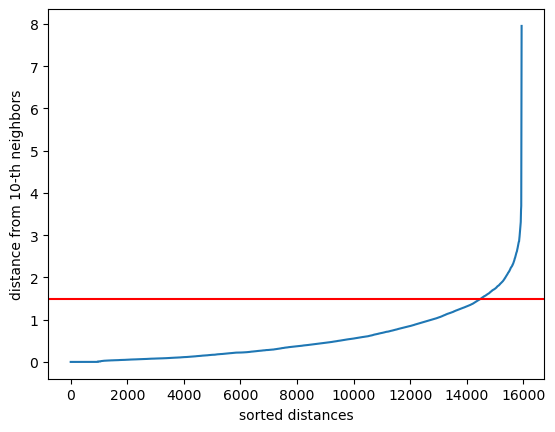

In [217]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.axhline(y=1.5, color='r', linestyle='-')
plt.ylabel(f'distance from {k}-th neighbors')
plt.xlabel('sorted distances')

We can identify the Elbow in the value of 1.5, so this value is a candidate for the Epsilon.

In [218]:
#Coarse grain search for the number of min_samples
#min_samples = [20, 40, 50, 75]
#Finer grain search for the number of min_samples
min_samples = [50, 60, 70, 75]

#Coarse grain search for the number of eps
#eps_l = [1.5, 1.6, 1.70]
#Finer grain search for the number of eps
eps_l = [1.45, 1.50, 1.55, 1.6]

In [219]:
from sklearn import metrics

table = []
for eps in eps_l:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(df_numeric)
        n_clusters = len(np.unique(dbscan.labels_))
        silhouette = metrics.silhouette_score(df_numeric, dbscan.labels_)
        DBscore = metrics.davies_bouldin_score(df_numeric, dbscan.labels_)
        table.append({"eps":eps, "silhouette": silhouette, "DBscore":DBscore, "n_clusters": n_clusters, "min_samples": min_sample})
        

In [220]:
pd.DataFrame(table).sort_values(by="silhouette", ascending=False)


,eps,silhouette,DBscore,n_clusters,min_samples
7,1.50,0.258646,1.966673,5,75
11,1.55,0.244792,1.882496,6,75
6,1.50,0.243314,1.885904,6,70
0,1.45,0.241814,1.826665,7,50
1,1.45,0.241164,1.891321,6,60
12,1.60,0.233594,2.136448,4,50
8,1.55,0.231881,2.142476,4,50
14,1.60,0.230683,2.086798,4,70
3,1.45,0.223360,1.802931,6,75
13,1.60,0.212916,1.975920,5,60


The best looking value of silhouette is the eps 1.9 which generates 3 clusters. With 10 samples

In [221]:
def dbscan_analysis(eps, min_samples):
    
    # Perform DB scan
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(df_numeric)
    print(f"noise points: {(dbscan.labels_==-1).sum()}")

    plt.figure(figsize=(8,8))
    #printing the scatter without -1 labels
    scatter = plt.scatter(df['pc1'][dbscan.labels_!=-1], df['pc2'][dbscan.labels_!=-1], c=dbscan.labels_[dbscan.labels_!=-1], s=10)
    #scatter = plt.scatter(df['pc1'], df['pc2'], c=dbscan.labels_, s=10)

    plt.tick_params(axis='both', which='major')
    plt.legend(*scatter.legend_elements())

    return dbscan.labels_

noise points: 2374


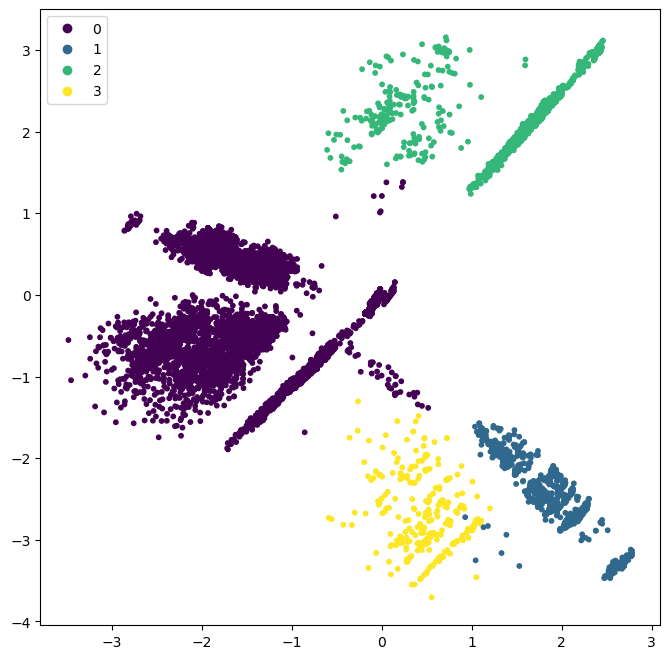

In [222]:
dbscan_labels = dbscan_analysis(1.5, 75)

In [223]:
#np.unique(dbscan.labels_, return_counts=True)

In [227]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(dbscan.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(dbscan.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [10766, 1536, 1494, 86, 49, 0]


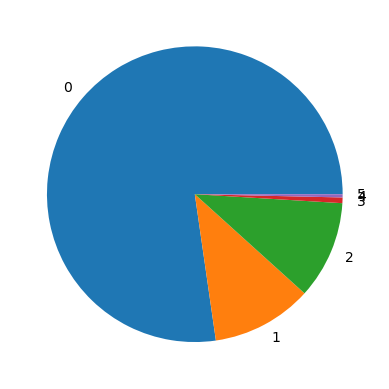

In [228]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

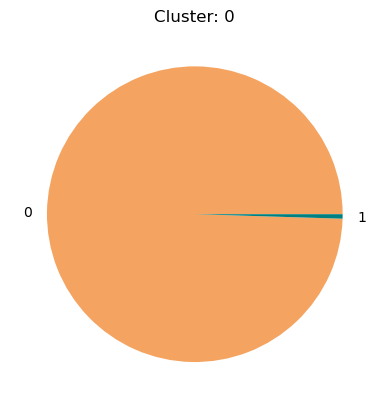

0    10714
1       52
Name: involve_killing, dtype: int64


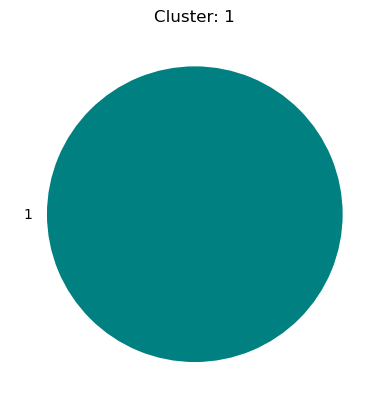

1    1536
Name: involve_killing, dtype: int64


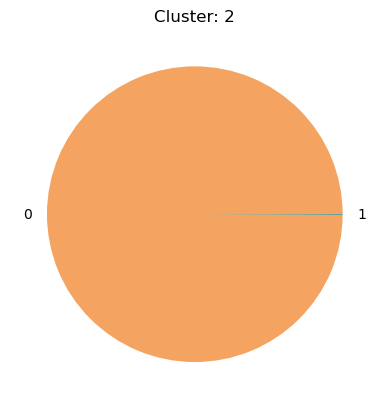

0    1493
1       1
Name: involve_killing, dtype: int64


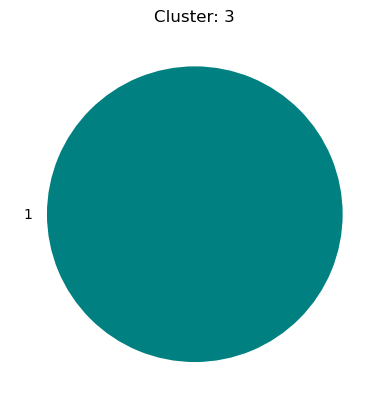

1    86
Name: involve_killing, dtype: int64


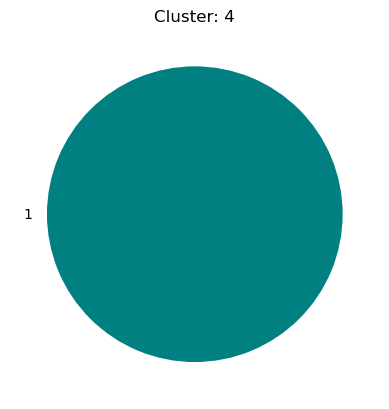

1    49
Name: involve_killing, dtype: int64


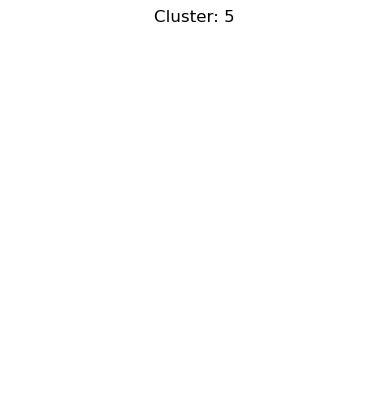

Series([], Name: involve_killing, dtype: int64)


In [229]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[dbscan.labels_ == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)